In [4]:
import numpy as np
from scipy.spatial import distance_matrix, Voronoi, Delaunay

# Generate E: 10 random 2D points
np.random.seed(42)
E = np.random.rand(10, 2) * 100

# a) Find the closest pair of points using a distance matrix
distances = distance_matrix(E, E)
np.fill_diagonal(distances, np.inf)  # ignore zero diagonal
min_dist = np.min(distances)
min_pair_indices = np.unravel_index(np.argmin(distances), distances.shape)
closest_pair = (E[min_pair_indices[0]], E[min_pair_indices[1]])

# b) Voronoi diagram using scipy (Fortune's algorithm approximation)
vor = Voronoi(E)

# c) Delaunay triangulation (dual graph of Voronoi)
tri = Delaunay(E)


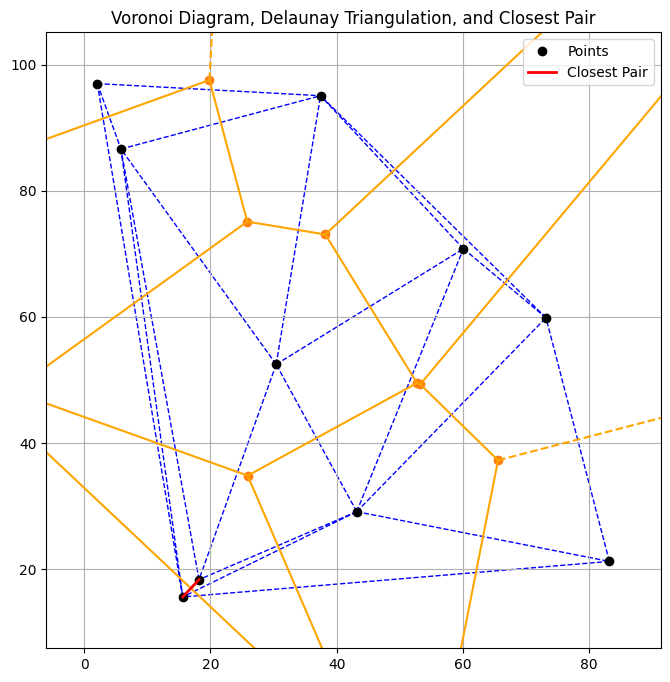

In [5]:
import matplotlib.pyplot as plt
from scipy.spatial import voronoi_plot_2d

# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 8))

# Plot Voronoi diagram
voronoi_plot_2d(vor, ax=ax, show_vertices=True, line_colors='orange', line_width=1.5, point_size=10)

# Plot Delaunay triangulation
ax.triplot(E[:, 0], E[:, 1], tri.simplices, color='blue', linestyle='--', linewidth=1)

# Plot points
ax.plot(E[:, 0], E[:, 1], 'ko', label='Points')

# Highlight closest pair
p1, p2 = closest_pair
ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'r-', linewidth=2, label='Closest Pair')

# Annotations
ax.legend()
ax.set_title("Voronoi Diagram, Delaunay Triangulation, and Closest Pair")
ax.set_aspect('equal')
plt.grid(True)
plt.show()
